Using this tutorial: https://medium.com/hockey-stick/tl-dr-bayesian-a-b-testing-with-python-c495d375db4d to help, I am practcing setting up the foundation for an A/B test wtih python!

# Set up the experiment
Run the test and record the success rate for each group and then
plot the distribution of the difference between the two samples.
Calculate relevant statistics to add insights.
Evaluate collection of the sample size (impacts could be how quickly do we need this insight, how many users do we want to impact if it is a bad experiment). 

# Content
For this example, let's imagaine a website that streems nature documentaries. We want to test if image B will influence more users to click and view the Birding Documentary than Image B.

# Image A - Original Image
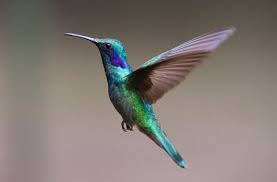

# Image B - Image We Think Can Beat the Original
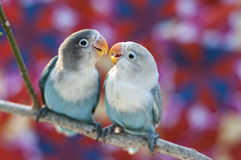

# Bayesian Statistics
The broad idea behind Bayesian conversion rate testing is to generate two distributions which cover all possible rates and then update them with information about the test performance and adjust our expectation of the most representative rate accordingly.

We can represent that here with a Beta distribution that has two parameters: α which represents successful conversions and β which represents people who exited without converting.

You can think of α and β like odds: 10:1, 2:3 etc. The one difference being that 4:6 represents a stronger belief in the same conversion rate than 2:3.

# Test Group
Let's select a small amount of our users to make sure that if it is a bad experiment it does not impact to many customers. We will take the group and split them into multiple variations of the same size, each of which having different pictures being advertised. For simplicity, we use 2 variations here: in the first users will see the original picture(Image A) and in the second users will see a picture we think that can beat the original (Image B).

Considering we have been using Image A, know a little bit about the likely conversion rates. We can use this information to dismiss unlikely outcomes / speed up test.

We know Image A has converts users to watch the documentary about about 10% of the time. To represent this we can use the distribution Beta(5, 45).

Both distributions are shown below. It’s worth playing around with these to see how the distribution changes.

In [18]:
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

people_in_branch = 5000

# Control is Image A, Experiment is Image B
control, experiment = np.random.rand(2, people_in_branch)

c_successes = sum(control < 0.10)

# Image B is about 10% better relative to Image A
e_successes = sum(experiment < 0.11)

c_failures = people_in_branch - c_successes
e_failures = people_in_branch - e_successes

# Our Priors
prior_successes = 500
prior_failures = 4500

What does our initial data look like?
Let’s take a look at our experiment results. The first thing we do is take our small amount of initial data and add our prior beliefs to both branches. After that we generate the posterior distributions, and make some graphs of the results.

[Text(0,0.5,'density'), Text(0.5,0,'conversion rate')]

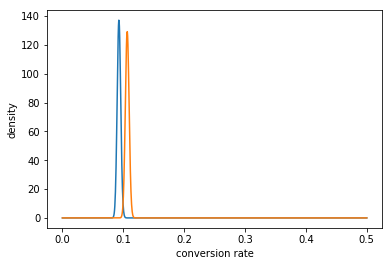

In [19]:
# For our graph
fig, ax = plt.subplots(1, 1) 

# Control
c_alpha, c_beta = c_successes + prior_successes, c_failures + prior_failures
# Experiment
e_alpha, e_beta = e_successes + prior_successes, e_failures + prior_failures

x = np.linspace(0., 0.5, 1000)

# Generate and plot the distributions!
c_distribution = beta(c_alpha, c_beta)
e_distribution = beta(e_alpha, e_beta)

ax.plot(x, c_distribution.pdf(x))
ax.plot(x, e_distribution.pdf(x))

ax.set(xlabel='conversion rate', ylabel='density')

# Bayesian Error Bars
A simple approach to comparing the two distributions is to generate error bars for each branch’s distribution. To do that we use the extremely useful CDF or Cumulative Distribution Function which turns a value in the distribution into its percentile rank.

What this means in practice is we can look at the y-axis and say things like “there’s an 80% chance the true conversion rate is below the corresponding x-axis value”.

For error bars we want to find the range captured by some arbitrary percentage, e.g. the 80% confidence interval. In this case we’d look for the median value and the 10% and 90% values of the CDF.

For a weak representation of a 30% conversion rate we can see the wide range the error bars cover:



In [20]:
# Arguments are x values so use ppf - the inverse of cdf
print(c_distribution.ppf([0.025, 0.5, 0.975]))
print(e_distribution.ppf([0.025, 0.5, 0.975]))

# [ 0.14443947  0.15530981  0.16661068]
# [ 0.15770843  0.16897057  0.18064618]

[0.08728829 0.09287286 0.09866594]
[0.10052928 0.10647377 0.11261979]


# It looks like Image B Wins

# Bayesian p-values
 Let’s make a Bayesian equivalent of p-values in order to answer “what is the probability that Image A is actually better than Image B.” We can try and achieve this by taking samples from both distributions and comparing which sample has the larger conversion rate. If we do this enough times we should get a pretty accurate read on the question above.



In [24]:
sample_size = 100000

c_samples = pd.Series([c_distribution.rvs() for _ in range(sample_size)])
e_samples = pd.Series([e_distribution.rvs() for _ in range(sample_size)])

p = 1.0 - sum(e_samples > c_samples)/sample_size
print(p)


0.0007099999999999884


# Image B is the winner
Our “p-value” is less than 0.05, so we can declare Bears the winner!



# Value of Test

 It makes sense to check just how much of an improvement we think the Experiment is vs. the Control.

To do this we can generate a CDF of the B samples over the A samples:

[Text(0,0.5,'CDF'), Text(0.5,0,'Image B / Image A')]

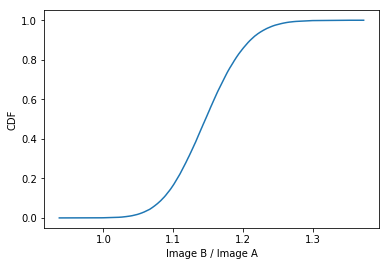

In [26]:
fig, ax = plt.subplots(1, 1)

ser = pd.Series(e_samples/c_samples)

# Make the CDF
ser = ser.sort_values()
ser[len(ser)] = ser.iloc[-1] 
cum_dist = np.linspace(0., 1., len(ser))
ser_cdf = pd.Series(cum_dist, index=ser)

ax.plot(ser_cdf)
ax.set(xlabel='Image B / Image A', ylabel='CDF')

There aren’t many values below 0 meaning the A branch didn’t win very often. Eyeballing the median we can see it’s pretty close to 1.1, agreeing with our initial “10% better” setting.